# Exploring `plasticparcels` physics kernels in an idealised flow
In this example, we will use `plasticparcels` and an idealised flow field to explore the different physics kernels available. The flow is based on the two-dimensional Bickley Jet flow, where we have included a depth dimension whereby the flow velocities linearly decay with depth. Note that the physical and biogeochemical fields used in this example are unrealistic and are used for demonstration purposes only.

In [2]:
# Library imports
from datetime import datetime, timedelta
import xarray as xr
import numpy as np

# parcels and plasticparcels imports
import plasticparcels as pp
import parcels


# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker

## Create an idealised flow
TODO: Add text

In [3]:
# Create the idealised flow fields
from example_idealised_flow_functions import *

# Times the analytic fieldset is evaluated on
times = np.arange(0, 5.1, 0.1) * 86400

fieldset = bickleyjet_fieldset_3d(times=times)
fieldset = add_uniform_temp_salt_field(fieldset, times)
fieldset = add_biogeochemistry_field(fieldset, times)
fieldset = add_wind_field(fieldset, times)
fieldset = add_stokes_field(fieldset, times)

# Add a periodic halo in the zonal direction
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

## Visualise the fields

/tmp/ipykernel_143539/2418834796.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cb = ax.pcolormesh(lon, lat, field_data, cmap=plt.cm.Spectral)


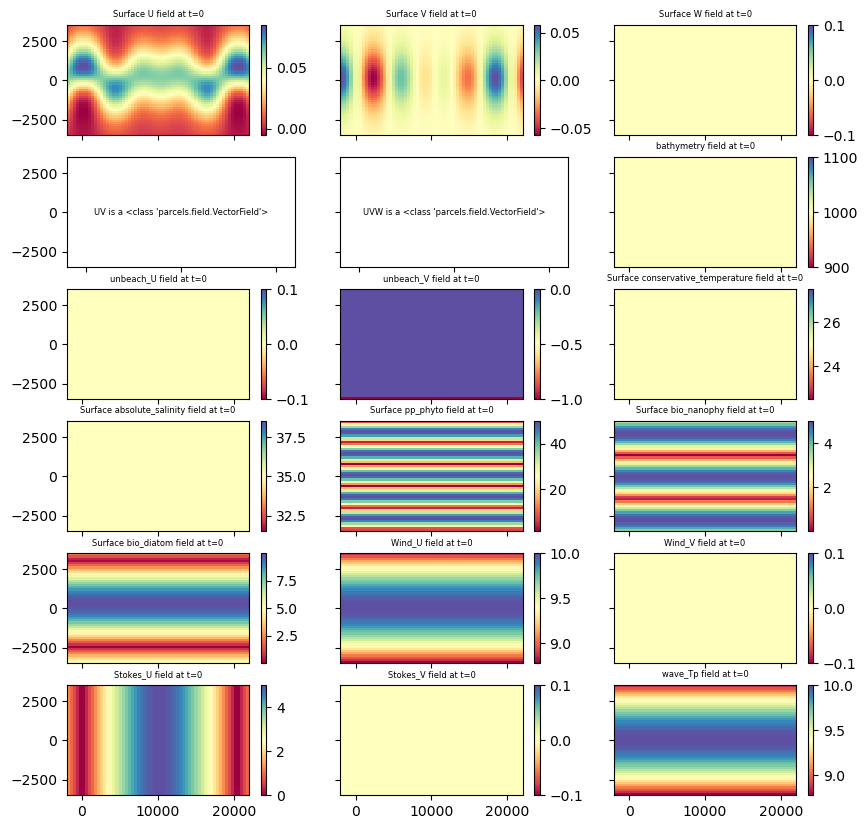

In [4]:
n_fields = len(fieldset.get_fields())
fig, axs = plt.subplots(6, 3, sharex=True, sharey=True, figsize=(10, 10))

# Loop over the fields in the fieldset, and plot them if they are Fields (and not VectorFields or NestedFields)
for i in range(n_fields):
    field = fieldset.get_fields()[i]
    ax = axs.flatten()[i]

    if type(field) == parcels.Field:
        lon, lat = np.meshgrid(field.grid.lon, field.grid.lat)
        # Plot the surface field, or simply the 2D field
        if len(field.data.shape) == 4:
            field_data = field.data[0,0,:,:]
            axes_title = f'Surface {field.name} field at t=0'
        else:
            field_data = field.data[0,:,:]
            axes_title = f'{field.name} field at t=0'
        
        # Plot the field
        cb = ax.pcolormesh(lon, lat, field_data, cmap=plt.cm.Spectral)
        ax.set_title(axes_title, fontsize=6)
        plt.colorbar(cb, ax=ax)
    else: # The field is a VectorField or NestedField
        ax.text(np.mean(lon), np.mean(lat), f'{field.name} is a {type(field)}', fontsize=6, ha='center', va='center')
            
plt.show()

## TODO: I would expect a 1.0 m/s velocity in the unbeach_V field at the top?


## Create a dictionary of settings
TODO: Add text

In [5]:
settings = {}
# Create the simulation settings
settings['simulation'] = {
    'runtime': timedelta(days=4),              # Runtime of simulation
    'outputdt': timedelta(hours=6),            # Timestep of output
    'dt': timedelta(minutes=5),                # Timestep of advection
    }

# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.1,   # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1028.,  # Plastic particle density (kg/m^3)
}

# Set the biogeochemical model settings
settings['bgc'] = {}
settings['bgc']['constants'] = {"biofilm_density": 1388.0,
                                "algae_cell_volume": 2e-16,
                                "K": 1.3805834190672156e-23,
                                "R20": 1.1574074074074074e-06,
                                "Q10": 2.13,
                                "Gamma": 2.0,
                                "carbon_molecular_weight": 12.0,
                                "collision_probability": 1.0,
                                "algae_mortality_rate": 1.0,
                                "algae_respiration_f": 1.0
                                }

for key in settings['bgc']['constants']:
    fieldset.add_constant(key, settings['bgc']['constants'][key])

# Set the physical model settings
fieldset.add_constant('use_3D', True)
fieldset.add_constant('use_mixing', False)
fieldset.add_constant('use_biofouling', True)
fieldset.add_constant('use_stokes', True)
fieldset.add_constant('use_wind', True)
fieldset.add_constant('G', 9.81)  # Gravitational constant [m s-1]
fieldset.add_constant('z_start', 0.0)
fieldset.add_constant('verbose_delete', 1)

In [6]:
# Define a custom kernel to handle the periodic boundary conditions
def ZonalBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west


## Create release settings

In [7]:
release_lons, release_lats = np.meshgrid(np.arange(0, 20000, 100), np.arange(-2000, 2000, 50))
release_locations = {'lons': release_lons, 'lats': release_lats}

In [8]:
runtime = settings['simulation']['runtime']
dt = settings['simulation']['dt']
outputdt = settings['simulation']['outputdt']

In [9]:
## TODO: Combine these into one function, not separated

def plot_particles(pset, release_lons):
    fig = plt.figure(figsize=(7, 5), constrained_layout=True)
    ax = fig.add_subplot(2,1,1)

    ax.set_ylabel('Meridional distance [m]')
    ax.set_xlim(0, 2e4)
    ax.set_ylim(-2500, 2500)
    cb = ax.scatter(pset.lon, pset.lat, c=release_lons.flatten(), s=1)
    plt.colorbar(cb, label='Initial zonal distance')
    plt.title(f'Particle positions at time {np.nan_to_num(pset[0].time, 0)}')

    
    ax = fig.add_subplot(2,1,2)
    ax.set_xlabel('Zonal distance [m]')
    ax.set_ylabel('Depth [m]')
    ax.set_xlim(0, 2e4)
    #ax.set_ylim(0, 1000)
    ax.yaxis.set_inverted(True)
    cb = ax.scatter(pset.lon, pset.depth, c=release_lons.flatten(), s=1)
    plt.colorbar(cb, label='Initial zonal distance')
    

    
    plt.show()

def plot_particles_pfile(pfile):

    fig = plt.figure(figsize=(7, 5), constrained_layout=True)
    ax = fig.add_subplot(2,1,1)

    ax.set_ylabel('Meridional distance [m]')
    ax.set_xlim(0, 2e4)
    ax.set_ylim(-2500, 2500)
    cb = ax.scatter(pfile['lon'].values[:,-2], pfile['lat'].values[:,-2], c=pfile['lon'].values[:,0], s=1)
    plt.colorbar(cb, label='Initial zonal distance')
    title_time = np.nan_to_num(pfile['time'].values[0,-2], pfile['time'].values[-1,-2])
    plt.title(f'Particle positions at time {title_time}')

    
    ax = fig.add_subplot(2,1,2)
    ax.set_xlabel('Zonal distance [m]')
    ax.set_ylabel('Depth [m]')
    ax.set_xlim(0, 2e4)
    #ax.set_ylim(0, 1000)
    ax.yaxis.set_inverted(True)
    cb = ax.scatter(pfile['lon'].values[:,-2], pfile['z'].values[:,-2], c=pfile['lon'].values[:,0], s=1)
    plt.colorbar(cb, label='Initial zonal distance')
    

    
    plt.show()

## Experiment 1: Idealised flow only
In this experiment we will simulate the dispersion of particles by the idealised flow alone. Of course, there may exist a density difference between the plastic particles and the background flow, resulting in a non-zero settling velocity until the particles become neutrally buoyant.

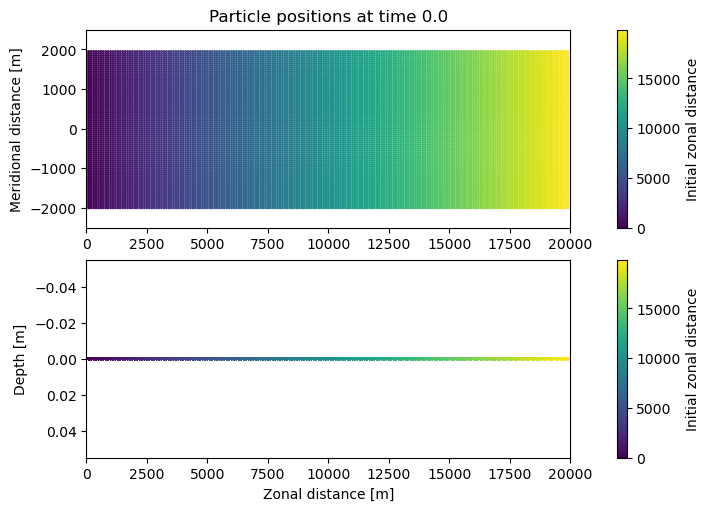

In [10]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = False
fieldset.use_stokes = False
fieldset.use_wind = False
settings['plastictype']['plastic_density'] = 1028.

# Create several particle sets for different simulations
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
plot_particles(pset, release_lons)


In [11]:
# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

# Replace the periodic boundary kernel
kernels[-2] = ZonalBC # Replace the longitudinal boundary kernel with a zonal boundary kernel #TODO: Explain this

INFO: Output files are stored in example_idealised_flow_experiment_1.zarr.
100%|██████████| 345600.0/345600.0 [00:47<00:00, 7252.16it/s]


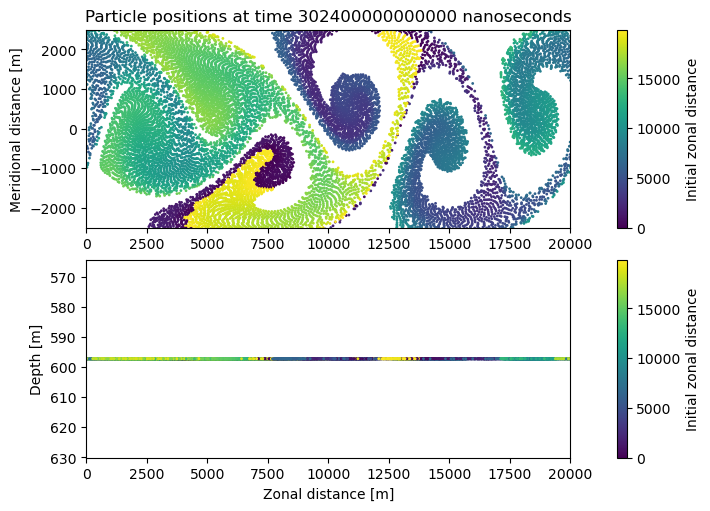

In [12]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_idealised_flow_experiment_1.zarr', pset, settings=settings, outputdt=outputdt)

# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

# Plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles_pfile(ds)


## Experiment 2: Idealised flow and wind
In this experiment we will simulate the dispersion of particles by the idealised flow, including the effects of wind. Again, there may exist a density difference between the plastic particles and the background flow, resulting in a non-zero settling velocity until the particles become neutrally buoyant. However, only particles at the surface are affected by the wind, so we will make our particles positively buoyant by initialising them a low density.

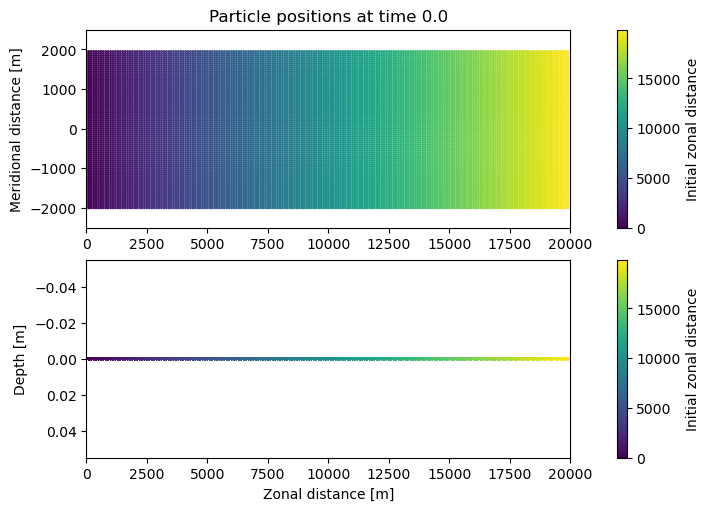

In [13]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = False
fieldset.use_stokes = False
fieldset.use_wind = True

settings['plastictype']['plastic_density'] = 1000.

# Create several particle sets for different simulations
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
plot_particles(pset, release_lons)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)
kernels[-2] = ZonalBC # Replace the longitudinal boundary kernel with a zonal boundary kernel

INFO: Output files are stored in example_idealised_flow_experiment_2.zarr.
100%|██████████| 345600.0/345600.0 [00:56<00:00, 6140.44it/s]


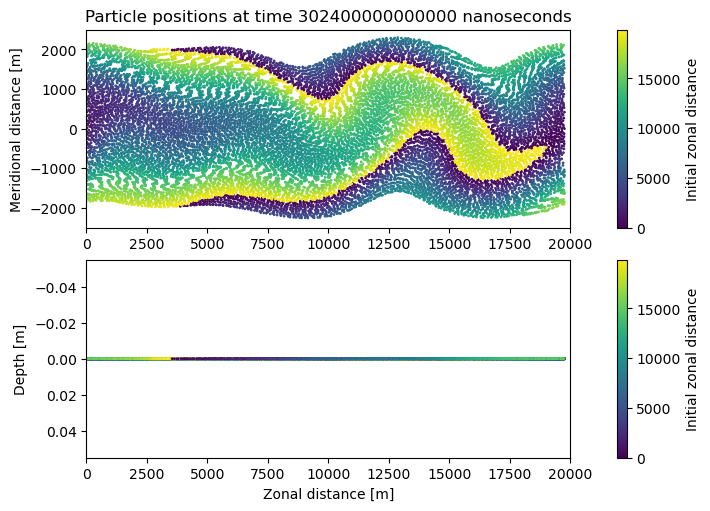

In [14]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_idealised_flow_experiment_2.zarr', pset, settings=settings, outputdt=outputdt)

# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

# Plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles_pfile(ds)

## Experiment 3: Idealised flow, wind, and waves
In this experiment we will simulate the dispersion of particles by the idealised flow, including the effects of wind and waves. Again, there may exist a density difference between the plastic particles and the background flow, resulting in a non-zero settling velocity until the particles become neutrally buoyant. Only particles at the surface are affected by the wind, but all particles experience a depth-decaying Stokes profile.

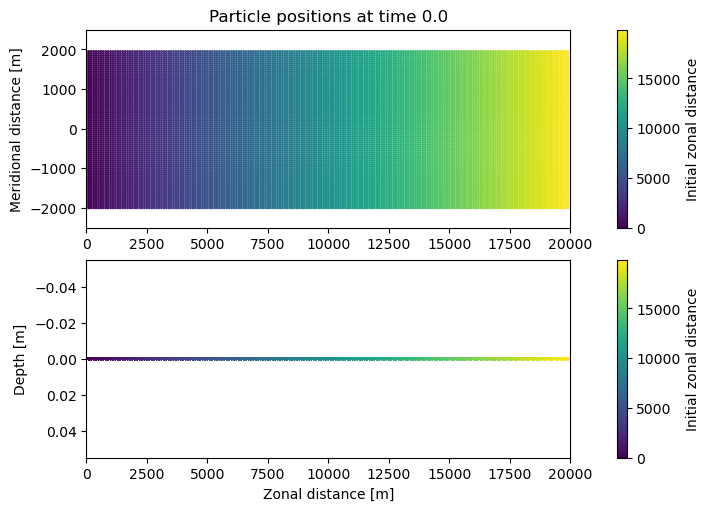

In [15]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = False
fieldset.use_stokes = True
fieldset.use_wind = True

settings['plastictype']['plastic_density'] = 1027.25 # TODO: Is this a good density to use?

# Create several particle sets for different simulations
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
plot_particles(pset, release_lons)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)
kernels[-2] = ZonalBC # Replace the longitudinal boundary kernel with a zonal boundary kernel

INFO: Output files are stored in example_idealised_flow_experiment_3.zarr.
100%|██████████| 345600.0/345600.0 [01:00<00:00, 5725.63it/s]


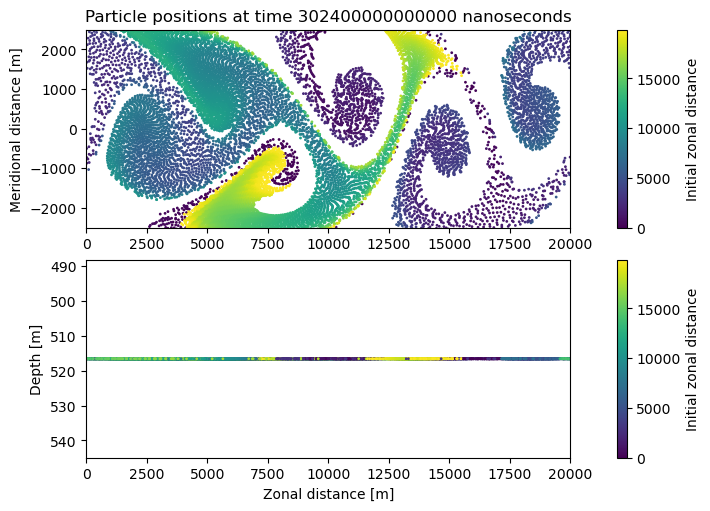

In [16]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_idealised_flow_experiment_3.zarr', pset, settings=settings, outputdt=outputdt)

# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

# Plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles_pfile(ds)

## Experiment 4: Idealised flow and biofouling
In this experiment we will simulate the dispersion of particles by the idealised flow, including the effects of biofouling.

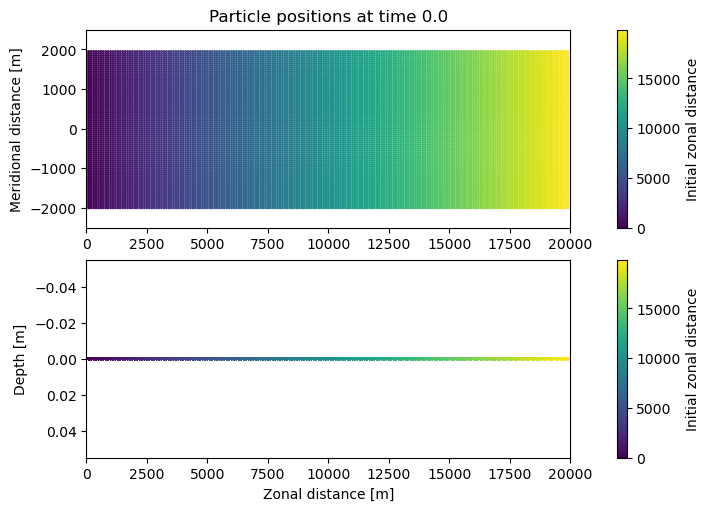

In [17]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = True
fieldset.use_stokes = False
fieldset.use_wind = False

settings['plastictype']['plastic_density'] = 1027.275 # What density to use?

# Create several particle sets for different simulations
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
plot_particles(pset, release_lons)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)
kernels[-2] = ZonalBC # Replace the longitudinal boundary kernel with a zonal boundary kernel

INFO: Output files are stored in example_idealised_flow_experiment_4.zarr.
100%|██████████| 345600.0/345600.0 [00:56<00:00, 6106.89it/s]


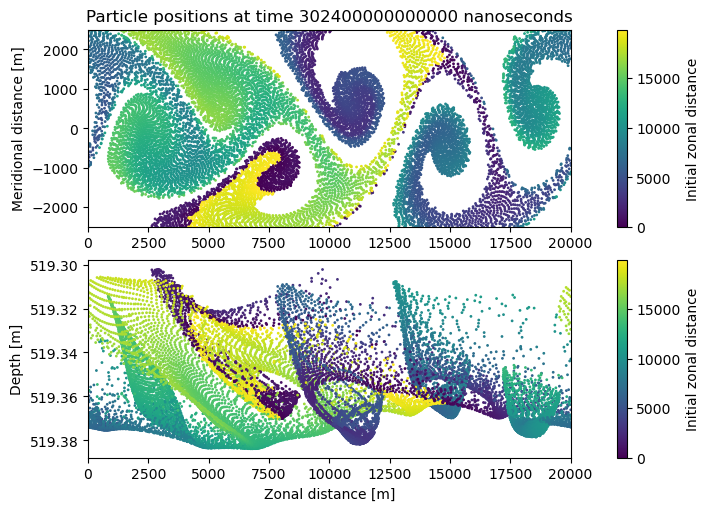

In [18]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_idealised_flow_experiment_4.zarr', pset, settings=settings, outputdt=outputdt)

# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

# Plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles_pfile(ds)

# I would expect way more variance, play with the settings to see if this is the case

## Experiment 5: All effects
In this experiment we will simulate the dispersion of particles by the idealised flow, including the effects of wind, waves, and biofouling.

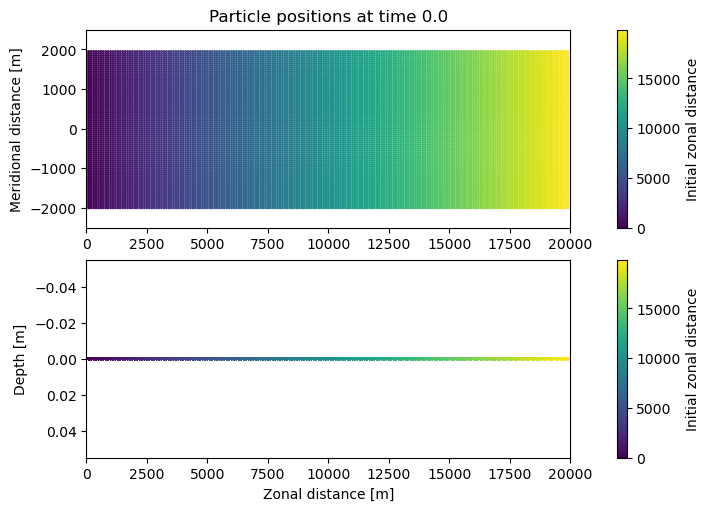

In [19]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = True
fieldset.use_stokes = True
fieldset.use_wind = True

settings['plastictype']['plastic_density'] = 1027.25

# Create several particle sets for different simulations
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
plot_particles(pset, release_lons)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)
kernels[-2] = ZonalBC # Replace the longitudinal boundary kernel with a zonal boundary kernel

INFO: Output files are stored in example_idealised_flow_experiment_5.zarr.
100%|██████████| 345600.0/345600.0 [01:09<00:00, 5006.95it/s]


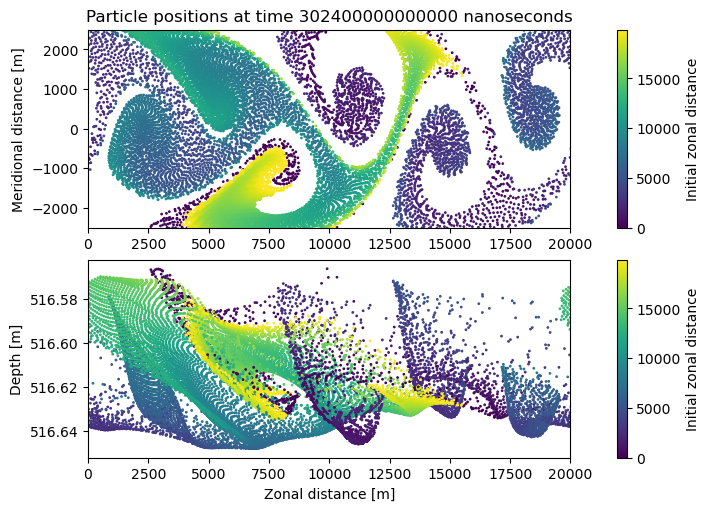

In [20]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_idealised_flow_experiment_5.zarr', pset, settings=settings, outputdt=outputdt)

# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

# Plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles_pfile(ds)

# I would expect way more variance, play with the settings to see if this is the case

## Comparing the results of all five experiments

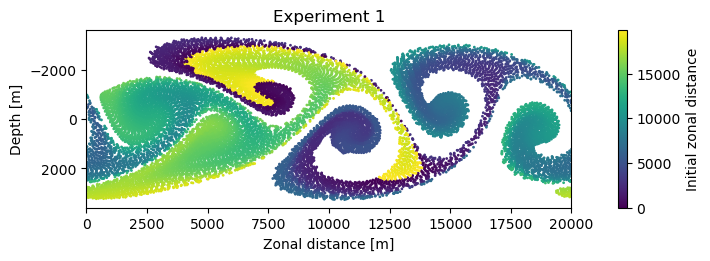

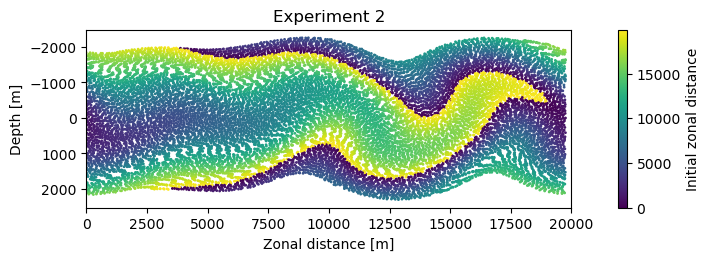

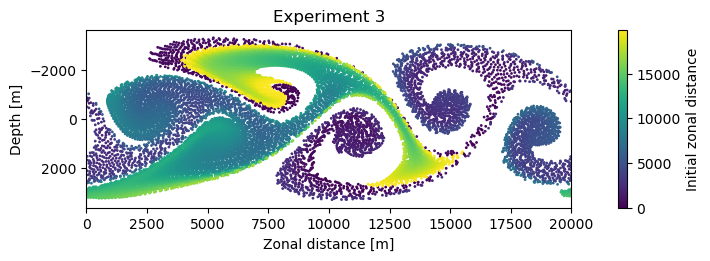

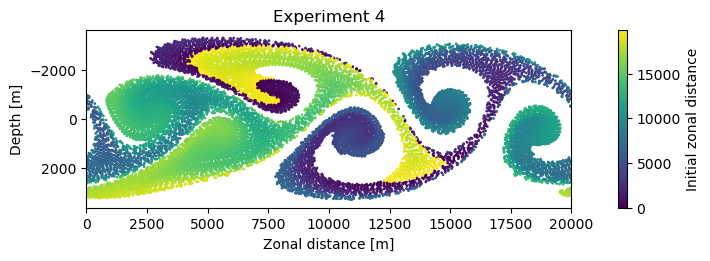

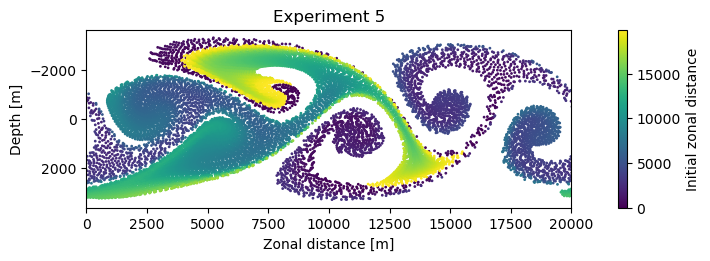

In [26]:
filenames = [f'example_idealised_flow_experiment_{i}.zarr' for i in range(1, 6)]

ds_list = []
for filename in filenames:
    ds_list.append(xr.open_zarr(filename))

for i, pfile in enumerate(ds_list):
    fig = plt.figure(figsize=(7, 2.5), constrained_layout=True)
    
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Zonal distance [m]')
    ax.set_ylabel('Depth [m]')
    ax.set_xlim(0, 2e4)
    
    ax.yaxis.set_inverted(True)
    cb = ax.scatter(pfile['lon'].values[:,-2], pfile['lat'].values[:,-2], c=pfile['lon'].values[:,0], s=1)
    plt.colorbar(cb, label='Initial zonal distance')
    plt.title(f'Experiment {i+1}')
    plt.show()


## This won't be in the tutorial, just me checking by hand what typical values of the surrounding sw density are

In [21]:
import math
Z = -50.  # note: use negative depths!
SA = 37.
CT = 22.

SAu = 40. * 35.16504 / 35.
CTu = 40.
Zu = 1.e+04
deltaS = 32.
R000 = 8.0189615746e+02
R100 = 8.6672408165e+02
R200 = -1.7864682637e+03
R300 = 2.0375295546e+03
R400 = -1.2849161071e+03
R500 = 4.3227585684e+02
R600 = -6.0579916612e+01
R010 = 2.6010145068e+01
R110 = -6.5281885265e+01
R210 = 8.1770425108e+01
R310 = -5.6888046321e+01
R410 = 1.7681814114e+01
R510 = -1.9193502195e+00
R020 = -3.7074170417e+01
R120 = 6.1548258127e+01
R220 = -6.0362551501e+01
R320 = 2.9130021253e+01
R420 = -5.4723692739e+00
R030 = 2.1661789529e+01
R130 = -3.3449108469e+01
R230 = 1.9717078466e+01
R330 = -3.1742946532e+00
R040 = -8.3627885467e+00
R140 = 1.1311538584e+01
R240 = -5.3563304045e+00
R050 = 5.4048723791e-01
R150 = 4.8169980163e-01
R060 = -1.9083568888e-01
R001 = 1.9681925209e+01
R101 = -4.2549998214e+01
R201 = 5.0774768218e+01
R301 = -3.0938076334e+01
R401 = 6.6051753097e+00
R011 = -1.3336301113e+01
R111 = -4.4870114575e+00
R211 = 5.0042598061e+00
R311 = -6.5399043664e-01
R021 = 6.7080479603e+00
R121 = 3.5063081279e+00
R221 = -1.8795372996e+00
R031 = -2.4649669534e+00
R131 = -5.5077101279e-01
R041 = 5.5927935970e-01
R002 = 2.0660924175e+00
R102 = -4.9527603989e+00
R202 = 2.5019633244e+00
R012 = 2.0564311499e+00
R112 = -2.1311365518e-01
R022 = -1.2419983026e+00
R003 = -2.3342758797e-02
R103 = -1.8507636718e-02
R013 = 3.7969820455e-01
ss = math.sqrt((SA + deltaS) / SAu)
tt = CT / CTu
zz = -Z / Zu
rz3 = R013 * tt + R103 * ss + R003
rz2 = (R022 * tt + R112 * ss + R012) * tt + (R202 * ss + R102) * ss + R002
rz1 = (((R041 * tt + R131 * ss + R031) * tt + (R221 * ss + R121) * ss + R021) * tt + ((R311 * ss + R211) * ss + R111) * ss + R011) * tt + (((R401 * ss + R301) * ss + R201) * ss + R101) * ss + R001
rz0 = (((((R060 * tt + R150 * ss + R050) * tt + (R240 * ss + R140) * ss + R040) * tt + ((R330 * ss + R230) * ss + R130) * ss + R030) * tt + (((R420 * ss + R320) * ss + R220) * ss + R120) * ss + R020) * tt + ((((R510 * ss + R410) * ss + R310) * ss + R210) * ss + R110) * ss + R010) * tt + (((((R600 * ss + R500) * ss + R400) * ss + R300) * ss + R200) * ss + R100) * ss + R000
sw_density = ((rz3 * zz + rz2) * zz + rz1) * zz + rz0

In [22]:
sw_density

1025.5708341596417